# Лабораторная работа №3

## Реализация сверточной нейронной сети

В работе предлагается использовать набор данных _notMNIST_, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (_A_ ... _J_, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Данные можно скачать по ссылке:

* https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);

* https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

### Задание 1

Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенной модели?

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

os.chdir(BASE_DIR)

In [0]:
import pandas as pd

dataframe = pd.read_pickle("./large.pkl")

In [4]:
! pip install tensorflow-gpu --pre --quiet

! pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astunparse, opt-einsum, six, absl-py, tensorflow-estimator, termcolor, grpcio, wrapt, h5py, gast, google-pasta, numpy, tensorboard, wheel, scipy, keras-preprocessing, protobuf
Required-by: 


In [0]:
import tensorflow as tf

In [0]:
# To fix memory leak: https://github.com/tensorflow/tensorflow/issues/33009

tf.compat.v1.disable_eager_execution()

In [0]:
import numpy as np

In [0]:
dataframe_test = dataframe.sample(frac = 0.1)

dataframe = dataframe.drop(dataframe_test.index)

In [9]:
x = np.asarray(list(dataframe['data']))[..., np.newaxis]

x = tf.keras.utils.normalize(x, axis = 1)

x.shape

(415751, 28, 28, 1)

In [10]:
x_test = np.asarray(list(dataframe_test['data']))[..., np.newaxis]

x_test = tf.keras.utils.normalize(x_test, axis = 1)

x_test.shape

(46195, 28, 28, 1)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

In [12]:
import seaborn as sns

from matplotlib import rcParams

rcParams['figure.figsize'] = 11.7, 8.27

sns.set()

sns.set_palette(sns.color_palette('hls'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


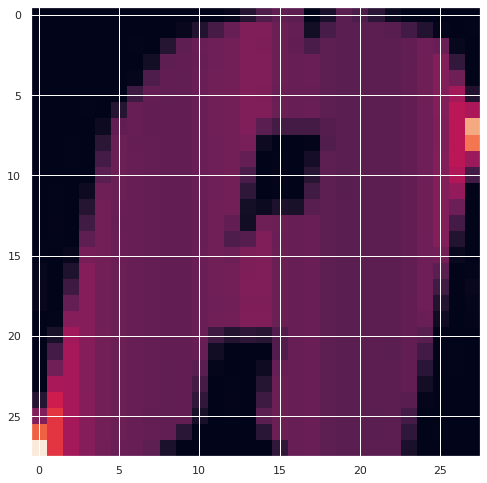

In [13]:
plt.imshow(x[100].squeeze())

plt.show()

In [0]:
IMAGE_DIM_0, IMAGE_DIM_1 = x.shape[1], x.shape[2]

In [15]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(dataframe['label'].astype('category').cat.codes.astype('int32'))

y.shape

(415751, 10)

In [16]:
y_test = to_categorical(dataframe_test['label'].astype('category').cat.codes.astype('int32'))

y_test.shape

(46195, 10)

In [0]:
CLASSES_N = y.shape[1]

In [0]:
DENSE_LAYER_WIDTH = 5000

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

model = tf.keras.Sequential()

model.add(Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(DENSE_LAYER_WIDTH, activation = 'relu'))
model.add(Dense(CLASSES_N))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def cat_cross_from_logits(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits = True)

model.compile(optimizer = 'sgd',
              loss = cat_cross_from_logits,
              metrics = ['categorical_accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 5000)              125445000 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
Total params: 125,499,810
Trainable params: 125,499,810
Non-trainable params: 0
_________________________________________________________________


In [0]:
VAL_SPLIT_RATE = 0.1

In [0]:
EPOCHS_N = 10

In [24]:
history = model.fit(x = x, y = y, epochs = EPOCHS_N, validation_split = VAL_SPLIT_RATE)

Train on 374175 samples, validate on 41576 samples
Epoch 1/10
374175/374175 [==============================] - 120s 321us/sample - loss: 0.4768 - categorical_accuracy: 0.8591 - val_loss: 3.3758 - val_categorical_accuracy: 0.1301
Epoch 2/10
374175/374175 [==============================] - 121s 324us/sample - loss: 0.3468 - categorical_accuracy: 0.8955 - val_loss: 2.2694 - val_categorical_accuracy: 0.4353
Epoch 3/10
374175/374175 [==============================] - 121s 324us/sample - loss: 0.2936 - categorical_accuracy: 0.9108 - val_loss: 2.3619 - val_categorical_accuracy: 0.4416
Epoch 4/10
374175/374175 [==============================] - 121s 322us/sample - loss: 0.2526 - categorical_accuracy: 0.9231 - val_loss: 2.0237 - val_categorical_accuracy: 0.5219
Epoch 5/10
374175/374175 [==============================] - 121s 323us/sample - loss: 0.2159 - categorical_accuracy: 0.9337 - val_loss: 2.3267 - val_categorical_accuracy: 0.4358
Epoch 6/10
374175/374175 [==============================] -

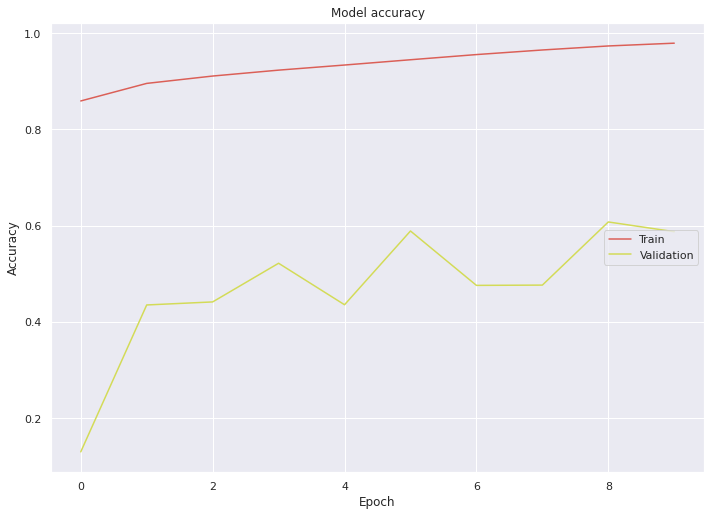

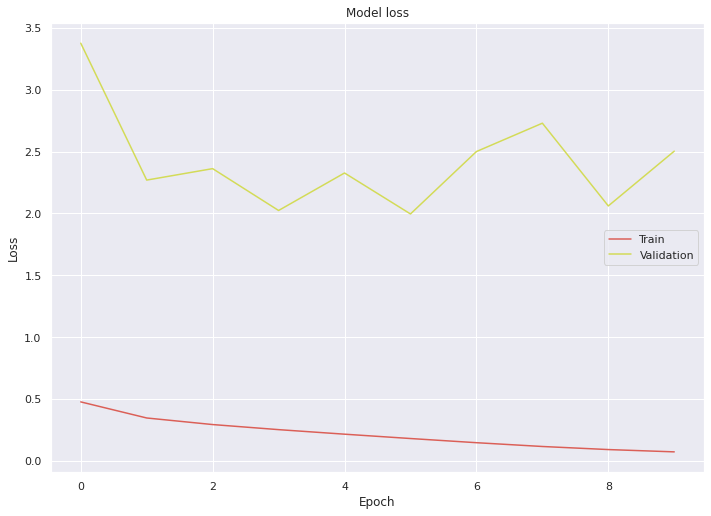

In [25]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

In [26]:
results = model.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results)

Test loss, test accuracy: [0.5405509961460728, 0.89239097]


Лучшая точность построенной модели на тестовой выборке составила 89%.

### Задание 2

Замените один из сверточных слоев на слой, реализующий операцию пулинга (_Pooling_) с функцией максимума или среднего. Как это повлияло на точность классификатора?

In [0]:
from tensorflow.keras.layers import MaxPooling2D

model_2 = tf.keras.Sequential()

model_2.add(Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model_2.add(MaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(DENSE_LAYER_WIDTH, activation = 'relu'))
model_2.add(Dense(CLASSES_N))

In [0]:
model_2.compile(optimizer = 'sgd',
               loss = cat_cross_from_logits,
               metrics = ['categorical_accuracy'])

In [29]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              15685000  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
Total params: 15,735,170
Trainable params: 15,735,170
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_2 = model_2.fit(x = x, y = y, epochs = EPOCHS_N, validation_split = VAL_SPLIT_RATE)

Train on 374175 samples, validate on 41576 samples
Epoch 1/10
374175/374175 [==============================] - 43s 114us/sample - loss: 0.5757 - categorical_accuracy: 0.8356 - val_loss: 3.3338 - val_categorical_accuracy: 0.0800
Epoch 2/10
374175/374175 [==============================] - 42s 112us/sample - loss: 0.4074 - categorical_accuracy: 0.8776 - val_loss: 2.9557 - val_categorical_accuracy: 0.2613
Epoch 3/10
374175/374175 [==============================] - 42s 112us/sample - loss: 0.3602 - categorical_accuracy: 0.8914 - val_loss: 2.9767 - val_categorical_accuracy: 0.2739
Epoch 4/10
374175/374175 [==============================] - 42s 112us/sample - loss: 0.3305 - categorical_accuracy: 0.8999 - val_loss: 2.4212 - val_categorical_accuracy: 0.3749
Epoch 5/10
374175/374175 [==============================] - 42s 113us/sample - loss: 0.3076 - categorical_accuracy: 0.9067 - val_loss: 2.4744 - val_categorical_accuracy: 0.3780
Epoch 6/10
374175/374175 [==============================] - 42s 

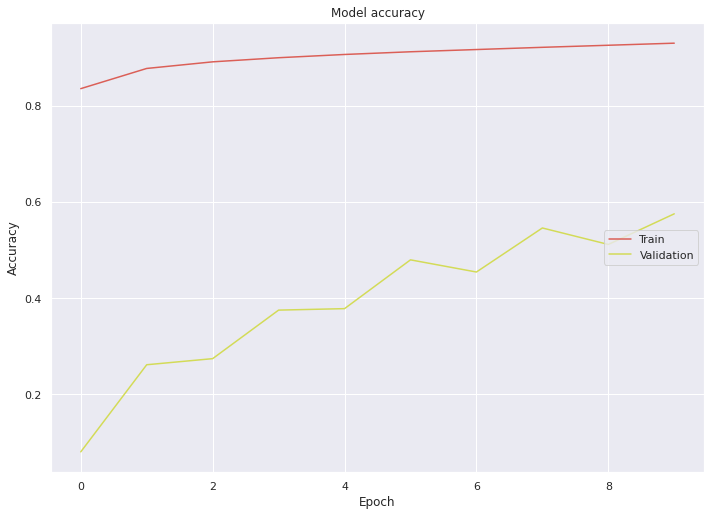

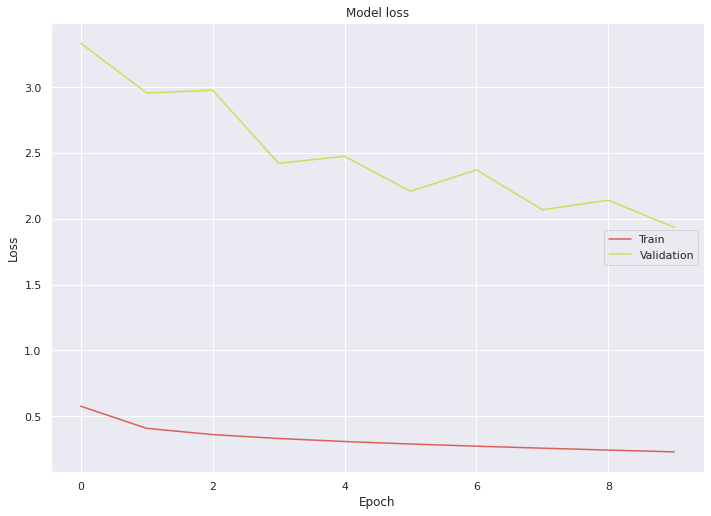

In [31]:
plt.plot(history_2.history['categorical_accuracy'])
plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

In [32]:
results_2 = model_2.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results_2)

Test loss, test accuracy: [0.45766007790563945, 0.87918603]


Замена свёрточного слоя на операцию пулинга снизила точность на тестовой выборке до 87%.

### Задание 3

Реализуйте классическую архитектуру сверточных сетей _LeNet-5_ (http://yann.lecun.com/exdb/lenet/).

In [0]:
from tensorflow.keras.layers import AveragePooling2D

model_3 = tf.keras.Sequential()

model_3.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = 'same',
                   input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model_3.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model_3.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = 'valid'))
model_3.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model_3.add(Flatten())
model_3.add(Dense(120, activation = 'tanh'))
model_3.add(Dense(84, activation = 'tanh'))
model_3.add(Dense(CLASSES_N, activation = 'softmax'))

In [0]:
model_3.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['categorical_accuracy'])

In [40]:
history_3 = model_3.fit(x = x, y = y, epochs = EPOCHS_N, validation_split = VAL_SPLIT_RATE)

Train on 374175 samples, validate on 41576 samples
Epoch 1/10
374175/374175 [==============================] - 39s 104us/sample - loss: 0.4516 - categorical_accuracy: 0.8618 - val_loss: 3.2148 - val_categorical_accuracy: 0.1163
Epoch 2/10
374175/374175 [==============================] - 39s 103us/sample - loss: 0.3568 - categorical_accuracy: 0.8898 - val_loss: 2.8585 - val_categorical_accuracy: 0.4042
Epoch 3/10
374175/374175 [==============================] - 39s 103us/sample - loss: 0.3279 - categorical_accuracy: 0.8980 - val_loss: 2.0824 - val_categorical_accuracy: 0.5103
Epoch 4/10
374175/374175 [==============================] - 39s 103us/sample - loss: 0.3107 - categorical_accuracy: 0.9030 - val_loss: 3.7105 - val_categorical_accuracy: 0.1722
Epoch 5/10
374175/374175 [==============================] - 39s 103us/sample - loss: 0.2994 - categorical_accuracy: 0.9060 - val_loss: 2.8629 - val_categorical_accuracy: 0.2903
Epoch 6/10
374175/374175 [==============================] - 38s 

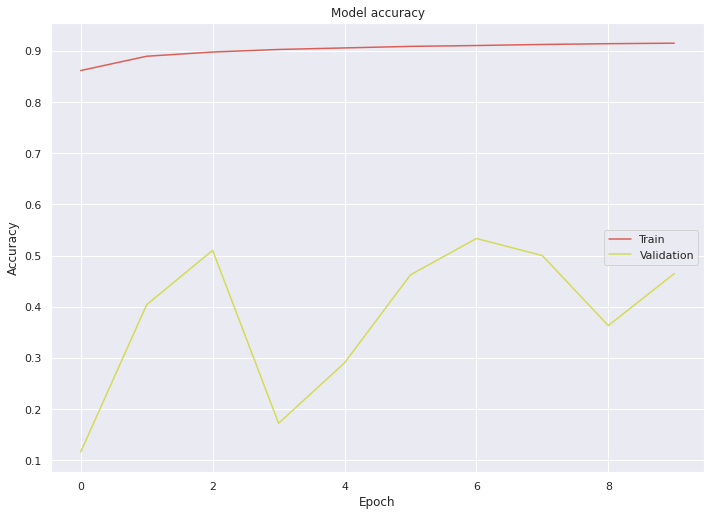

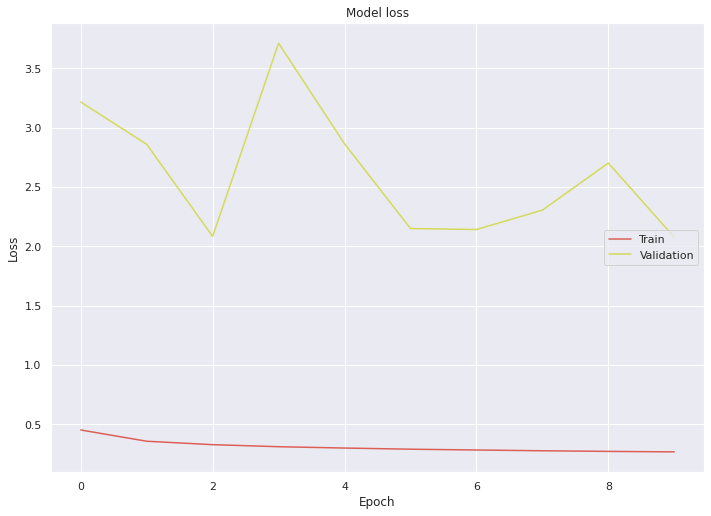

In [41]:
plt.plot(history_3.history['categorical_accuracy'])
plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'right')
plt.show()

In [42]:
results_3 = model_3.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results_3)

Test loss, test accuracy: [0.4807648109272324, 0.85974675]


Удивительно, но _LeNet-5_ показала результат хуже, чем первая и вторая модель &mdash; 85% на тестовой выборке. Объяснить это можно тем, что первая модель содержит свёрточный слой с большей выходной размерностью.

### Задание 4

Сравните максимальные точности моделей, построенных в лабораторных работах 1-3. Как можно объяснить полученные различия?

Результаты на валидационной выборке:

* логистическая регрессия &mdash; 81%;

* модель с только полносвязными слоями &mdash; 10%;

    * с регуляризацией и сбросом нейронов &mdash; 62%;

        * с адаптивным шагом &mdash; 72%;

* модель с двумя свёрточными слоями и одним полносвязным &mdash; 89%;

* модель с одним свёрточным слоем, операцией пулинга и одним полносвязным &mdash; 87%;

* _LeNet-5_ &mdash; два свёрточных слоя, две операции пулинга, два полносвязных слоя &mdash; 85%.

Объяснение превосходства свёрточных сетей над полносвязными &mdash; такая архитектура просто предназначена для работы с изображениями.